<a href="https://colab.research.google.com/github/rtrochepy/astronomer/blob/main/preprocess_v001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# !pip install tqdm
# !pip install imbalanced-learn

# Documentación del Proceso de Preprocesamiento y Análisis de Datos

## Importar Librerías

In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from joblib import dump, load
from scipy.stats import skew, kurtosis
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

## Leer el Dataset

El primer paso consiste en cargar el conjunto de datos en el entorno de trabajo para su análisis y preprocesamiento.

In [3]:
# Ignorar advertencias de pandas para una ejecución más limpia
warnings.filterwarnings('ignore')

# Configuración de pandas para mostrar todas las columnas al imprimir
pd.set_option('display.max_columns', None)

In [4]:
# Lee el archivo CSV.  Error handling mejorado.
try:
    df = pd.read_csv("data_labels.csv")
except FileNotFoundError:
    print("Error: El archivo 'data_labels.csv' no se encuentra.")
except pd.errors.EmptyDataError:
    print("Error: El archivo 'data_labels.csv' está vacío.")
except pd.errors.ParserError:
    print("Error: Error al analizar el archivo 'data_labels.csv'.")

In [5]:
# ver cuantas filas y columnas tiene (90009 filas, 191 columnas)
df.shape

(90009, 191)

In [6]:
print(f"Filas cargadas: {len(df)}")

Filas cargadas: 90009


In [7]:
# Mostrar las primeras filas y la forma inicial del DataFrame
print("Primeras filas del DataFrame:")
print(df.head())
print("\nDimensiones del DataFrame (filas, columnas):", df.shape)

Primeras filas del DataFrame:
                                                  ID Expenditure_AHF  \
0  1547558447248542464208633772467833372637054433...      2017-10-23   
1  8303023334174375372752224543342433062237135032...      2017-05-16   
2  6205323654737347834626173852036442544385334747...      2017-12-15   
3  3727835411357335232137873674310300621187543222...      2018-02-02   
4  3526827315715777302832343600863305043273474403...      2017-05-31   

   Payment_6804  Infraction_CGP  Base_7744  Base_80863  Risk_1930  \
0      0.983147        0.001925   0.024150    1.009185   0.006479   
1      0.845400        0.001012   0.032260    1.008112   0.001539   
2      0.773748        0.008989   0.007325    0.817528   0.008786   
3      0.853480        0.653419   0.107481    0.816447   0.007058   
4      0.632887        0.000809   0.009320    0.812306   0.001417   

   Expenditure_JIG  Infraction_SNZ  Base_02683  Infraction_SBF  \
0         0.104240        0.005930    0.008182          

## Tratamiento de Valores Nulos (Missing Values)

In [8]:
# Verificar valores nulos en cada columna
nulos_por_columna = df.isnull().sum()

# Filtrar solo las columnas que tienen valores nulos
nulos_por_columna = nulos_por_columna[nulos_por_columna > 0]

# Mostrar columnas con valores nulos y su cantidad
print("Columnas con valores nulos:\n", nulos_por_columna)


Columnas con valores nulos:
 Payment_6804         527
Base_80863             4
Expenditure_JIG    15851
Infraction_SNZ         4
Base_02683             4
                   ...  
Infraction_QGR       851
Infraction_ZTLC    73406
Infraction_LSX       851
Infraction_IBJ       257
Infraction_DNOU      851
Length: 118, dtype: int64


### Eliminación de Columnas con Más del 50% de Valores Nulos

- Las columnas con más del 50% de valores nulos se eliminan del dataset, ya que estimar una gran cantidad de datos faltantes puede distorsionar significativamente los resultados.

In [9]:
# Definir el umbral para eliminar columnas (en este caso, más del 50% de valores faltantes)
umbral = 0.5 * df.shape[0]  # 50% del total de filas

# Identificar columnas que cumplen el criterio de eliminación
columnas_a_eliminar = nulos_por_columna[nulos_por_columna > umbral].index
print("Columnas eliminadas por tener más del 50% de valores nulos:", columnas_a_eliminar.tolist())

# Eliminar las columnas con más del 50% de valores faltantes
df = df.drop(columns=columnas_a_eliminar)

# Mostrar el DataFrame actualizado
print("DataFrame actualizado:\n", df)

Columnas eliminadas por tener más del 50% de valores nulos: ['Infraction_SBF', 'Infraction_NCB', 'Infraction_CLLY', 'Infraction_GWL', 'Infraction_GEL', 'Expenditure_KMW', 'Base_8318', 'Infraction_HPS', 'Infraction_JVWF', 'Infraction_APIU', 'Risk_5797', 'Infraction_FUSM', 'Base_8379', 'Infraction_IRKE', 'Infraction_WEG', 'Infraction_ZVHJ', 'Infraction_ANHZ', 'Risk_4561', 'Infraction_HPLO', 'Infraction_QGC', 'Infraction_EBA', 'Base_64022', 'Base_3958', 'Infraction_WLMI', 'Infraction_SVKR', 'Infraction_MAN', 'Infraction_WWLN', 'Infraction_ADWZ', 'Infraction_MZI', 'Infraction_ZTLC']
DataFrame actualizado:
                                                       ID Expenditure_AHF  \
0      1547558447248542464208633772467833372637054433...      2017-10-23   
1      8303023334174375372752224543342433062237135032...      2017-05-16   
2      6205323654737347834626173852036442544385334747...      2017-12-15   
3      3727835411357335232137873674310300621187543222...      2018-02-02   
4      352

### Tratamiento de valores faltantes en variables numéricas

La imputación de una gran cantidad de valores faltantes en una columna puede distorsionar los resultados y comprometer la calidad del análisis. Por ello, se ha optado por dividir las columnas en grupos según el tipo de dato y el porcentaje de valores nulos que contienen, con el fin de aplicar estrategias de imputación específicas y optimizadas para cada caso.

**Estrategia de imputación por porcentaje de valores nulos:**

1. **Columnas con menos del 10% de valores nulos (`low_null_columns`)**  
   Estas columnas presentan pocos valores faltantes, por lo que la imputación mediante la **media** es adecuada. Esta estrategia garantiza que la distribución general de los datos no se vea significativamente alterada.

2. **Columnas con entre 10% y 30% de valores nulos (`mid_null_columns`)**  
   Dado que el impacto de los valores atípicos podría ser mayor en este rango, se ha decidido utilizar la **mediana** como método de imputación. La mediana es una opción robusta y menos sensible a outliers, preservando mejor la representatividad de los datos.

3. **Columnas con más del 30% de valores nulos (`high_null_columns`)**  
   En este caso, el alto porcentaje de valores faltantes requiere técnicas más avanzadas. Se recomienda el uso de **Iterative Imputer**, un enfoque que utiliza regresión iterativa para predecir los valores faltantes en función de las relaciones entre las columnas. Esto permite una imputación más precisa y contextual.

**Nota:** La elección de cada técnica se basa en análisis previo y en recomendaciones de la literatura, priorizando la robustez y la minimización del sesgo en los datos.


In [10]:
# Importar librerías necesarias
from sklearn.experimental import enable_iterative_imputer  # Habilitar Iterative Imputer
from sklearn.impute import IterativeImputer

# Definir las columnas no numéricas
no_numerical = [
    'ID', 'Expenditure_AHF', 'Infraction_YFSG', 'Infraction_DQLY', 'Infraction_CLH',
    'Base_67254', 'Infraction_TEN', 'Base_8730', 'Base_23737', 'Infraction_NMCB',
    'Infraction_ZRH', 'Infraction_WIS', 'Infraction_WMAQ', 'label'
]

# Seleccionar solo las columnas numéricas
numerical_columns = [col for col in df.columns if col not in no_numerical]

# Calcular el porcentaje de valores nulos en cada columna numérica
porcentaje_null = df[numerical_columns].isnull().mean() * 100

# Agrupar columnas en función del porcentaje de valores nulos
low_null_columns = porcentaje_null[porcentaje_null < 10].index  # Menos del 10% de nulos
mid_null_columns = porcentaje_null[(porcentaje_null >= 10) & (porcentaje_null < 30)].index  # Entre 10% y 30% de nulos
high_null_columns = porcentaje_null[porcentaje_null >= 30].index  # Más del 30% de nulos

# Tratamiento de valores nulos basado en los grupos
# Menos del 10% de nulos - rellenar con la media
if len(low_null_columns) > 0:
    df[low_null_columns] = df[low_null_columns].fillna(df[low_null_columns].mean())
    print(f"Rellenado con la media para columnas con menos del 10% de nulos: {list(low_null_columns)}")

# Entre 10% y 30% de nulos - rellenar con la mediana
if len(mid_null_columns) > 0:
    df[mid_null_columns] = df[mid_null_columns].fillna(df[mid_null_columns].median())
    print(f"Rellenado con la mediana para columnas con entre 10% y 30% de nulos: {list(mid_null_columns)}")

# Más del 30% de nulos - usa técnicas avanzadas como Iterative Imputer
if len(high_null_columns) > 0:
    imputer = IterativeImputer()
    df[high_null_columns] = imputer.fit_transform(df[high_null_columns])
    print(f"Imputación avanzada para columnas con más del 30% de nulos: {list(high_null_columns)}")

# Mostrar un resumen del tratamiento de nulos
print("\nResumen del tratamiento de valores nulos:")
print(f"Total columnas con menos del 10% de nulos: {len(low_null_columns)}")
print(f"Total columnas con entre 10% y 30% de nulos: {len(mid_null_columns)}")
print(f"Total columnas con más del 30% de nulos: {len(high_null_columns)}")


Rellenado con la media para columnas con menos del 10% de nulos: ['Payment_6804', 'Infraction_CGP', 'Base_7744', 'Base_80863', 'Risk_1930', 'Infraction_SNZ', 'Base_02683', 'Infraction_QJJF', 'Base_76065', 'Infraction_EJZ', 'Base_6872', 'Risk_0322', 'Infraction_GGO', 'Base_1165', 'Base_39598', 'Base_6187', 'Infraction_ZTNC', 'Base_85131', 'Risk_9995', 'Infraction_AYWV', 'Payment_22507', 'Base_9516', 'Expenditure_YTR', 'Base_36384', 'Expenditure_FIP', 'Infraction_PAS', 'Risk_0003', 'Base_24406', 'Expenditure_LMSR', 'Infraction_BSU', 'Base_14808', 'Risk_8065', 'Infraction_ZYW', 'Base_1039', 'Infraction_HSSU', 'Infraction_EHZP', 'Infraction_TBP', 'Base_0580', 'Expenditure_RGD', 'Infraction_AQO', 'Base_0229', 'Base_69608', 'Base_91828', 'Base_6852', 'Expenditure_IDZ', 'Risk_1475', 'Expenditure_BWX', 'Base_8511', 'Infraction_JYZB', 'Base_22178', 'Infraction_ZTYG', 'Infraction_ZVW', 'Infraction_EYU', 'Expenditure_UWVG', 'Base_3041', 'Payment_3207', 'Infraction_QKZN', 'Infraction_CZE', 'Base_6

### Tratamiento de valores faltantes en variables categóricas

Para manejar los valores faltantes en columnas categóricas, se ha decidido rellenarlos creando una nueva categoría etiquetada como `"Missing"`. Este enfoque tiene varias ventajas clave:  
- **Preservación de información:** Mantiene la señal de que faltaban datos, lo que podría ser relevante para el modelo.  
- **Evita sesgo:** No altera la distribución original de las categorías.  
- **Identificación de patrones:** Permite al modelo aprender posibles relaciones entre los datos faltantes y otras variables.

Adicionalmente, se ha convertido cada columna categórica al tipo `Categorical`, lo que optimiza el uso de memoria, mejora la eficiencia del procesamiento y facilita el manejo de estas columnas en pandas.

#### Estrategias específicas para el tratamiento de datos categóricos

1. **Binning para columnas ordinales con múltiples niveles detallados:**  
   Columnas como `Infraction_CLH`, `Base_67254`, `Infraction_TEN` tienen categorías ordenadas (`very_high`, `high`, `moderate_high`, `very_low`, etc.).  
   - Se agrupan en categorías más generales (`low`, `moderate`, `high`) para reducir la dimensionalidad sin perder información relevante.  
   - Este enfoque conserva el orden inherente a los datos y permite al modelo detectar patrones con mayor facilidad.  

2. **One-Hot Encoding para columnas nominales sin orden:**  
   Columnas como `Infraction_YFSG` y `Infraction_DQLY` no presentan un orden jerárquico y contienen categorías independientes (por ejemplo, distintos tipos de infracciones).  
   - Se aplica **One-Hot Encoding**, que transforma cada categoría en una columna binaria.  
   - Este método es ideal para modelos de machine learning que no manejan datos categóricos directamente, preservando la naturaleza independiente de las categorías.  

3. **One-Hot Encoding para columnas con pocos valores numéricos:**  
   Columnas como `Base_8730` e `Infraction_WMAQ` tienen valores numéricos limitados (por ejemplo, 0, 1, 2), pero estos no representan cantidades ni un orden claro.  
   - Se tratan como categorías distintas mediante **One-Hot Encoding**, evitando imponer una relación de magnitud o jerarquía que no existe.

4. **Label Encoding para columnas binarias:**  
   Columnas como `Base_23737`, `Infraction_NMCB`, `Infraction_ZRH`, e `Infraction_WIS` tienen solo dos valores (por ejemplo, 0 y 1, o algún valor junto con `"Missing"`).  
   - Se utiliza **Label Encoding**, asignando valores numéricos simples (0 y 1) a las categorías.  
   - Esto es suficiente para columnas binarias, evitando la redundancia de aplicar One-Hot Encoding.

5. **Columna `label` (target):**  
   La columna objetivo ya es binaria (0 y 1) y no requiere procesamiento adicional.


In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Definir las variables categóricas
categoricas = [
    'Infraction_YFSG', 'Infraction_DQLY', 'Infraction_CLH', 'Base_67254', 'Infraction_TEN',
    'Base_8730', 'Base_23737', 'Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS',
    'Infraction_WMAQ'
]

# Mostrar las categorías únicas de cada variable categórica
print("Categorías únicas por variable categórica:")
for col in categoricas:
    print(f"{col}: {df[col].unique()}")

# Rellenar valores faltantes en variables categóricas con 'Missing'
df[categoricas] = df[categoricas].fillna('Missing')

# Verificar que los valores faltantes fueron rellenados
print("\nVerificación de valores después del relleno:")
for col in categoricas:
    print(f"{col}: {df[col].unique()}")

# Convertir columnas categóricas a tipo 'category'
df[categoricas] = df[categoricas].astype('category')

# Definir función para aplicar binning a columnas con orden implícito, incluyendo la categoría 'Missing'
def binarize_levels_with_missing(value):
    if value == 'Missing':
        return 'Missing'
    elif value in ['very_low', 'low', 'moderate_low', 'extremely_low']:
        return 'low'
    elif value in ['moderate', 'moderate_high']:
        return 'moderate'
    else:
        return 'high'

# Aplicar binning a columnas categóricas con orden implícito
ordered_columns = ['Infraction_CLH', 'Base_67254', 'Infraction_TEN']
for col in ordered_columns:
    df[col] = df[col].apply(binarize_levels_with_missing)

# Aplicar One-Hot Encoding para las columnas categóricas con binning
df = pd.get_dummies(df, columns=ordered_columns, drop_first=False)

# Aplicar One-Hot Encoding para columnas categóricas sin orden implícito
unordered_columns = ['Infraction_YFSG', 'Infraction_DQLY']
df = pd.get_dummies(df, columns=unordered_columns, drop_first=False)

# Aplicar One-Hot Encoding para columnas categóricas con valores numéricos y pocos valores distintos
few_values_columns = ['Base_8730', 'Infraction_WMAQ']
df = pd.get_dummies(df, columns=few_values_columns, drop_first=False)

# Manejo de columnas binarias, asegurando compatibilidad de tipo antes de Label Encoding
binary_columns = ['Base_23737', 'Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS']
df[binary_columns] = df[binary_columns].astype(str)

# Aplicar Label Encoding a columnas binarias
le = LabelEncoder()
for col in binary_columns:
    df[col] = le.fit_transform(df[col])

# Verificar que la columna 'label' solo contiene valores binarios (1, 0)
print("\nValores únicos en la columna 'label':", df['label'].unique())

# Convertir la columna 'Expenditure_AHF' a formato datetime
df['Expenditure_AHF'] = pd.to_datetime(df['Expenditure_AHF'], errors='coerce')

# Establecer la columna 'ID' como índice
df = df.set_index('ID')

# Mostrar las primeras filas del DataFrame modificado
print("\nDataFrame modificado:")
print(df.head())

# Comprobar si quedan valores nulos
nulos_por_columna_2 = df.isnull().sum()
nulos_por_columna_2 = nulos_por_columna_2[nulos_por_columna_2 > 0]
if not nulos_por_columna_2.empty:
    print("\nColumnas con valores nulos restantes:")
    print(nulos_por_columna_2)
else:
    print("\nNo hay valores nulos restantes.")


Categorías únicas por variable categórica:
Infraction_YFSG: ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
Infraction_DQLY: ['O' 'R' '-1' 'U' nan]
Infraction_CLH: ['very_high' 'high' 'moderate_high' 'very_low' 'moderate_low' 'moderate'
 'low' nan]
Base_67254: ['moderate_low' 'low' 'moderate' 'extremely_high' 'high' 'moderate_high'
 'very_high' nan]
Infraction_TEN: ['moderate_high' 'moderate' 'extremely_low' 'very_high' 'high'
 'moderate_low' 'low' nan]
Base_8730: [ 0.  1.  2. nan]
Base_23737: [1 0]
Infraction_NMCB: [ 1.  0. nan]
Infraction_ZRH: [ 0. nan  1.]
Infraction_WIS: [ 0.  1. nan]
Infraction_WMAQ: [ 1.  0. -1. nan]

Verificación de valores después del relleno:
Infraction_YFSG: ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
Infraction_DQLY: ['O' 'R' '-1' 'U' 'Missing']
Infraction_CLH: ['very_high' 'high' 'moderate_high' 'very_low' 'moderate_low' 'moderate'
 'low' 'Missing']
Base_67254: ['moderate_low' 'low' 'moderate' 'extremely_high' 'high' 'moderate_high'
 'very_high' 'Missing']
Infraction_TEN: ['moderate_h

In [12]:
# Seleccionar solo las columnas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Visualización de la distribución de las variables numéricas

Antes de avanzar con la detección de outliers y el escalado de las variables numéricas, es fundamental comprender cómo están distribuidos los datos. Esto permite identificar posibles patrones, asimetrías, o irregularidades que puedan influir en el análisis posterior.

Por ello, se graficarán las distribuciones de las variables numéricas para obtener una visión clara y preliminar de su comportamiento.

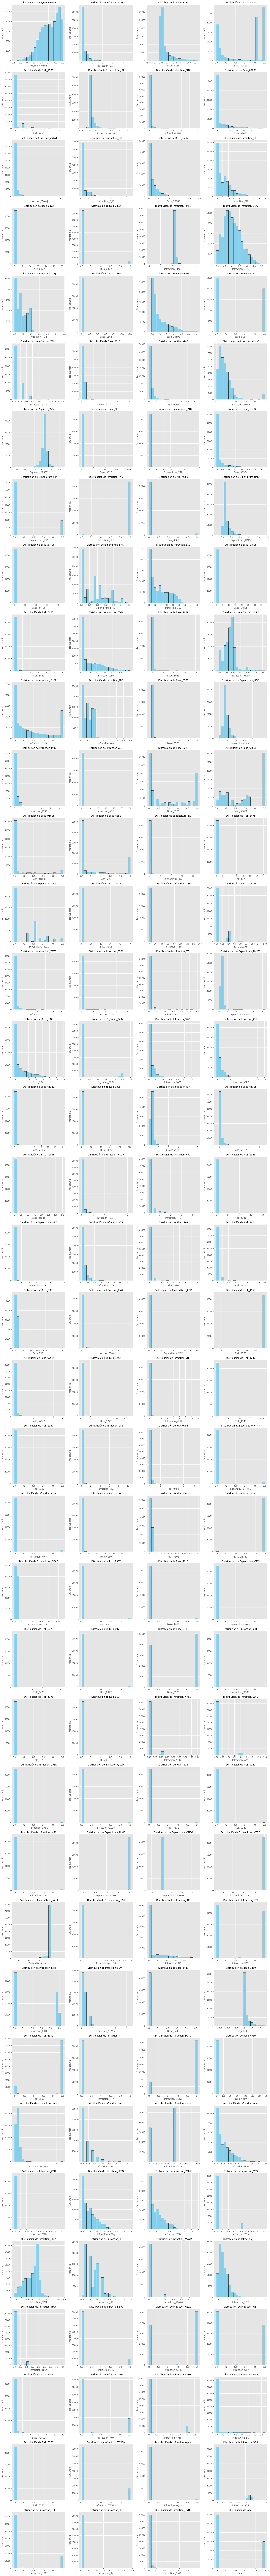

In [13]:
import matplotlib.pyplot as plt

# Configuración de estilo para los gráficos
plt.style.use('ggplot')  # Usar un estilo visual agradable

# Crear una cuadrícula de subplots para histogramas
num_cols = len(numeric_columns)  # Número de columnas numéricas
cols = 4  # Número de columnas en la cuadrícula
rows = -(-num_cols // cols)  # Calcular filas necesarias (redondeo hacia arriba)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))  # Configurar el tamaño del grid
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Graficar histogramas para cada columna
for i, col in enumerate(numeric_columns):
    ax = axes[i]
    df[col].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f"Distribución de {col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")

# Ocultar cualquier subplot vacío
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout para evitar superposición
plt.tight_layout()
plt.show()


# Detección de outliers

La investigación realizada sugiere las siguientes estrategias para identificar outliers:  

- **Método del Rango Intercuartílico (IQR):**  
  Ideal para distribuciones que no son normales y aplicable a cualquier tipo de distribución, ya que se basa en la posición relativa de los datos en lugar de asumir una forma específica.  

- **Z-score:**  
  Útil para detectar outliers en datos con una distribución aproximadamente normal o cuando no es posible determinar la distribución con precisión. Este método evalúa qué tan alejados están los valores en términos de desviaciones estándar de la media.

Dado que, como se observó en la visualización previa de las distribuciones, las variables numéricas no presentan generalmente una distribución normal, se opta por utilizar el método **IQR** para la detección de outliers.  


In [14]:
import pandas as pd

# Configurar la visualización completa para Pandas (solo para grandes conjuntos de datos)
pd.set_option('display.max_rows', None)

# Calcular el primer y tercer cuartil (Q1 y Q3) para columnas numéricas
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1  # Rango intercuartílico

# Identificar outliers como valores fuera de 1.5 veces el IQR
outliers_iqr = (df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))

# Contar el número de outliers por columna
outliers_count_iqr = outliers_iqr.sum(axis=0)
print("Número de outliers por columna (IQR):")
print(outliers_count_iqr)

# Número total de filas en el DataFrame
total_rows = len(df)

# Calcular el porcentaje de outliers en cada columna
outliers_percentage = (outliers_count_iqr / total_rows) * 100
print("\nPorcentaje de outliers por columna (IQR):")
print(outliers_percentage)

# Crear un resumen consolidado para una mejor visualización
outliers_summary = pd.DataFrame({
    'Número de outliers': outliers_count_iqr,
    'Porcentaje de outliers': outliers_percentage
}).sort_values(by='Porcentaje de outliers', ascending=False)

# Mostrar el resumen de outliers
print("\nResumen consolidado de outliers (IQR):")
print(outliers_summary)

# Opcional: Restaurar la configuración de visualización de Pandas
pd.reset_option('display.max_rows')


Número de outliers por columna (IQR):
Payment_6804          139
Infraction_CGP       6582
Base_7744           11229
Base_80863              0
Risk_1930           13878
Expenditure_JIG     13138
Infraction_SNZ      13702
Base_02683           9575
Infraction_ZWWJ     10223
Infraction_QJJF     14261
Base_76065           4947
Infraction_EJZ       2784
Base_6872           12907
Risk_0322            4820
Infraction_FMXQ     14542
Infraction_GGO        513
Infraction_TLPJ        12
Base_1165            2254
Base_39598           3345
Base_6187               0
Infraction_ZTNC      1887
Base_85131            819
Risk_9995           13058
Infraction_AYWV      3788
Payment_22507        7625
Base_9516            1108
Expenditure_YTR     10785
Base_36384          12188
Expenditure_FIP     19202
Infraction_PAS       2154
Risk_0003            3002
Expenditure_HMO      7064
Base_24406          11190
Expenditure_LMSR       72
Infraction_BSU          5
Base_14808           9020
Risk_8065            3227


# Tratamiento de outliers

De acuerdo con la investigación, es crucial tratar los outliers antes de normalizar o estandarizar los datos. Esto se debe a que los valores extremos pueden distorsionar significativamente estos procesos, afectando tanto la distribución de los datos como el rendimiento de los modelos posteriores.

Se ha optado por el cálculo del porcentaje de outliers en cada columna utilizando el método del **Rango Intercuartílico (IQR)**, que identifica valores que están por encima de 1.5 veces el IQR desde el primer y tercer cuartil. Este enfoque es especialmente efectivo para datos con distribuciones no normales.

### Estrategias para el tratamiento de outliers según su proporción:

1. **Columnas con menos del 5% de outliers:**  
   - **Estrategia:** Eliminación de los outliers.  
   - **Justificación:** Representan una pequeña proporción de los datos, por lo que su eliminación tiene un impacto mínimo en la cantidad total de información. Los valores extremos en estas columnas probablemente no aportan patrones relevantes, y su eliminación mejora la calidad del dataset sin pérdida significativa de información.

2. **Columnas con entre el 5% y el 15% de outliers:**  
   - **Estrategia:** Reemplazo de los outliers con los límites del IQR (mínimo o máximo permitido por el rango intercuartílico).  
   - **Justificación:** Eliminar este porcentaje de outliers podría llevar a una pérdida considerable de datos. Reemplazarlos suaviza su impacto, manteniendo todas las filas en el dataset y reduciendo la influencia de los valores extremos sin eliminarlos.

3. **Columnas con más del 15% de outliers:**  
   - **Estrategia:** Aplicación de transformaciones logarítmicas o de raíz cuadrada.  
   - **Justificación:** Dado que más del 15% de los datos contienen valores extremos, eliminarlos o reemplazarlos podría alterar sustancialmente la estructura de los datos y posiblemente eliminar patrones importantes.  
     - **Transformación logarítmica:** Útil para datos con crecimiento exponencial o gran variabilidad, ya que comprime los valores extremos.  
     - **Transformación de raíz cuadrada:** Suaviza la dispersión sin comprimir tanto como el logaritmo, siendo ideal para datos con variabilidad moderada.


In [15]:
import numpy as np

# Filtrar columnas con menos del 5% de outliers
minor_outlier_columns = outliers_percentage[outliers_percentage < 5].index

# Eliminar filas con outliers en estas columnas
for col in minor_outlier_columns:
    lower_limit = Q1[col] - 1.5 * IQR[col]
    upper_limit = Q3[col] + 1.5 * IQR[col]
    df = df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]

print(f"Se eliminaron outliers de las columnas con menos del 5% de outliers: {list(minor_outlier_columns)}")

# Filtrar columnas con entre 5% y 15% de outliers
moderate_outlier_columns = outliers_percentage[(outliers_percentage >= 5) & (outliers_percentage <= 15)].index

# Reemplazar outliers en estas columnas con los límites de IQR
for col in moderate_outlier_columns:
    lower_limit = Q1[col] - 1.5 * IQR[col]
    upper_limit = Q3[col] + 1.5 * IQR[col]
    df[col] = np.where(df[col] < lower_limit, lower_limit,
                       np.where(df[col] > upper_limit, upper_limit, df[col]))

print(f"Se reemplazaron outliers en columnas con entre 5% y 15% de outliers: {list(moderate_outlier_columns)}")

# Filtrar columnas con más del 15% de outliers
high_outlier_columns = outliers_percentage[outliers_percentage > 15].index

# Opcional: decidir cómo manejar estas columnas (por ejemplo, excluirlas o usar técnicas avanzadas)
print(f"Columnas con más del 15% de outliers: {list(high_outlier_columns)}")


Se eliminaron outliers de las columnas con menos del 5% de outliers: ['Payment_6804', 'Base_80863', 'Infraction_EJZ', 'Infraction_GGO', 'Infraction_TLPJ', 'Base_1165', 'Base_39598', 'Base_6187', 'Infraction_ZTNC', 'Base_85131', 'Infraction_AYWV', 'Base_9516', 'Infraction_PAS', 'Risk_0003', 'Expenditure_LMSR', 'Infraction_BSU', 'Risk_8065', 'Infraction_ZYW', 'Infraction_HSSU', 'Infraction_EHZP', 'Infraction_TBP', 'Base_0229', 'Base_69608', 'Base_6852', 'Risk_1475', 'Expenditure_BWX', 'Base_8511', 'Infraction_ZTYG', 'Expenditure_UWVG', 'Base_3041', 'Infraction_QKZN', 'Infraction_CZE', 'Base_65352', 'Risk_7095', 'Risk_6346', 'Expenditure_HRQ', 'Base_7331', 'Infraction_XWX', 'Risk_4553', 'Risk_8742', 'Infraction_VHU', 'Risk_4247', 'Risk_2380', 'Expenditure_HKXV', 'Infraction_MHM', 'Risk_4160', 'Risk_3506', 'Base_23737', 'Expenditure_GCAO', 'Risk_9367', 'Base_7910', 'Expenditure_GMC', 'Risk_9423', 'Risk_6977', 'Base_9103', 'Infraction_KSBR', 'Risk_6178', 'Risk_6197', 'Infraction_QVSL', 'Inf

### Selección del método de transformación

Cuando los outliers representan un patrón potencialmente relevante, pero es necesario reducir su impacto en el análisis, se pueden aplicar **transformaciones logarítmicas** o de **raíz cuadrada**. Estas transformaciones son especialmente útiles para:  
- Distribuciones con **colas largas**.  
- Variables con **escalas muy diferentes**.  

**Justificación del enfoque:**  
Cuando más del 15% de las observaciones en una columna son identificadas como outliers, estos valores podrían no ser verdaderamente "atípicos", sino representar una parte significativa o característica del dataset. En estos casos:  
- **Eliminar** o **reemplazar** los valores extremos con límites como los del IQR podría distorsionar los patrones inherentes de los datos.  
- **Transformaciones** como el logaritmo o la raíz cuadrada reducen la influencia de los valores extremos sin alterar la estructura subyacente de los datos.  

**Ventajas de aplicar transformaciones:**  
1. Reducen el impacto de la **asimetría** y los valores extremos en los datos.  
2. Facilitan una detección más precisa de outliers.  
3. Mejoran la calidad de los datos para el entrenamiento de modelos, al hacerlos más manejables y consistentes.  

Este enfoque no elimina información valiosa, sino que permite una representación más equilibrada de los datos para análisis posteriores.  


In [16]:
import numpy as np
from scipy.stats import skew

# Evaluar y decidir transformaciones basadas en skewness y kurtosis
transform_recommendations = {}
for col in high_outlier_columns:
    original_skew = skew(df[col].dropna())
    log_skew = skew(np.log1p(df[col].dropna().clip(lower=0)))  # Evitar valores negativos o nulos
    sqrt_skew = skew(np.sqrt(df[col].dropna().clip(lower=0)))  # Evitar valores negativos

    print(f'Columna: {col}')
    print(f'  Skew original: {original_skew:.3f}')
    print(f'  Skew logaritmo: {log_skew:.3f}')
    print(f'  Skew raíz cuadrada: {sqrt_skew:.3f}')

    if abs(log_skew) < abs(sqrt_skew):
        recommendation = 'log'
        print(f'  Transformación recomendada: Logaritmo\n')
    else:
        recommendation = 'sqrt'
        print(f'  Transformación recomendada: Raíz Cuadrada\n')

    transform_recommendations[col] = recommendation

# Separar columnas para cada transformación basada en las recomendaciones
sqrt_columns = [col for col, trans in transform_recommendations.items() if trans == 'sqrt']
log_columns = [col for col, trans in transform_recommendations.items() if trans == 'log']

print("Columnas recomendadas para transformación raíz cuadrada:", sqrt_columns)
print("Columnas recomendadas para transformación logarítmica:", log_columns)

# Aplicar transformaciones - Raíz cuadrada
for col in sqrt_columns:
    if col in df.columns:
        df[col] = np.sqrt(df[col].clip(lower=0))  # Manejar valores negativos

# Aplicar transformaciones - Logarítmica
for col in log_columns:
    if col in df.columns:
        df[col] = np.log1p(df[col].clip(lower=0))  # Manejar ceros y valores negativos

# Verificar skewness después de las transformaciones
print("\nSkewness después de las transformaciones:")
for col in sqrt_columns + log_columns:
    if col in df.columns:
        transformed_skew = skew(df[col].dropna())
        print(f'  Columna: {col}, Skewness transformada: {transformed_skew:.3f}')


Columna: Risk_1930
  Skew original: 5.457
  Skew logaritmo: 5.210
  Skew raíz cuadrada: 4.674
  Transformación recomendada: Raíz Cuadrada

Columna: Infraction_SNZ
  Skew original: 5.666
  Skew logaritmo: 4.715
  Skew raíz cuadrada: 3.573
  Transformación recomendada: Raíz Cuadrada

Columna: Infraction_QJJF
  Skew original: 2.690
  Skew logaritmo: 2.258
  Skew raíz cuadrada: 1.513
  Transformación recomendada: Raíz Cuadrada

Columna: Infraction_FMXQ
  Skew original: 0.634
  Skew logaritmo: -0.105
  Skew raíz cuadrada: -2.188
  Transformación recomendada: Logaritmo

Columna: Expenditure_FIP
  Skew original: 1.041
  Skew logaritmo: 1.041
  Skew raíz cuadrada: 1.033
  Transformación recomendada: Raíz Cuadrada

Columna: Base_0580
  Skew original: 8.709
  Skew logaritmo: 7.078
  Skew raíz cuadrada: 4.756
  Transformación recomendada: Raíz Cuadrada

Columna: Base_91828
  Skew original: 2.220
  Skew logaritmo: 2.025
  Skew raíz cuadrada: 1.701
  Transformación recomendada: Raíz Cuadrada

Colum

# División de los datos en variables predictoras (X) y variable objetivo (y)

1. **Conversión de columnas categóricas:**  
   - Las columnas `Infraction_NMCB`, `Infraction_ZRH`, y `Infraction_WIS` se convierten de tipo `int` a `category`.  
   - **Justificación:** Estas columnas tienen valores como `0`, `1`, y `2`, que no representan cantidades numéricas, sino categorías. Realizar esta conversión evita que se interpreten como números enteros durante el procesamiento.

2. **Conversión de columnas booleanas:**  
   - Las columnas de tipo `bool` se convierten a `int`.  
   - **Justificación:** Algunos modelos de machine learning no soportan directamente el tipo `bool`. Convertirlas a `int` asegura compatibilidad, representando `True` como `1` y `False` como `0`.

3. **Eliminación de columnas sin variabilidad:**  
   - Se elimina la columna `Base_23737` porque tiene un único valor (`1`) en todas las filas.  
   - **Justificación:** Una columna sin variabilidad no aporta información útil para el modelo y puede generar ruido innecesario.

4. **Eliminación de la columna de fecha:**  
   - Se elimina la columna `fecha`, ya que no parece tener una relación directa con la variable objetivo.  
   - **Justificación:** La columna parece ser únicamente una marca temporal y no aporta información relevante para el problema de predicción.

In [17]:
# Verificar valores únicos en columnas específicas
print("Valores únicos en columnas de interés:")
print("label:", df.label.unique())
print("Infraction_WIS:", df.Infraction_WIS.unique())
print("Infraction_ZRH:", df.Infraction_ZRH.unique())
print("Infraction_NMCB:", df.Infraction_NMCB.unique())
print("Base_23737:", df.Base_23737.unique())

# Convertir columnas categóricas con valores int a tipo 'category'
categorical_int_columns = ['Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS']
for col in categorical_int_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')
        print(f"Columna {col} convertida a 'category'.")

# Convertir columnas booleanas a tipo int
boolean_columns = df.select_dtypes(include=['bool']).columns
if not boolean_columns.empty:
    df[boolean_columns] = df[boolean_columns].astype(int)
    print(f"Columnas booleanas convertidas a 'int': {list(boolean_columns)}")

# Eliminar columnas constantes o no útiles
columns_to_drop = ['Expenditure_AHF', 'Base_23737']
columns_dropped = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=columns_dropped)
print(f"Columnas eliminadas: {columns_dropped}")

# Verificar tipos de datos después de las transformaciones
print("\nTipos de datos después de las transformaciones:")
print(df.dtypes)

# Verificar valores nulos en el DataFrame
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores únicos en columnas de interés:
label: [0 1]
Infraction_WIS: [0.]
Infraction_ZRH: [0]
Infraction_NMCB: [1 0]
Base_23737: [1]
Columna Infraction_NMCB convertida a 'category'.
Columna Infraction_ZRH convertida a 'category'.
Columna Infraction_WIS convertida a 'category'.
Columnas booleanas convertidas a 'int': ['Infraction_CLH_Missing', 'Infraction_CLH_high', 'Infraction_CLH_low', 'Infraction_CLH_moderate', 'Base_67254_Missing', 'Base_67254_high', 'Base_67254_low', 'Base_67254_moderate', 'Infraction_TEN_Missing', 'Infraction_TEN_high', 'Infraction_TEN_low', 'Infraction_TEN_moderate', 'Infraction_YFSG_CL', 'Infraction_YFSG_CO', 'Infraction_YFSG_CR', 'Infraction_YFSG_XL', 'Infraction_YFSG_XM', 'Infraction_YFSG_XZ', 'Infraction_DQLY_-1', 'Infraction_DQLY_Missing', 'Infraction_DQLY_O', 'Infraction_DQLY_R', 'Infraction_DQLY_U', 'Base_8730_0.0', 'Base_8730_1.0', 'Base_8730_2.0', 'Base_8730_Missing', 'Infraction_WMAQ_-1.0', 'Infraction_WMAQ_0.0', 'Infraction_WMAQ_1.0', 'Infraction_WMAQ_M

### División de los datos en variables predictoras (X) y variable objetivo (y)

En este paso, separamos la variable objetivo (`label`), que es el objetivo de la predicción, del resto de las variables predictoras.  

- **Importancia:** La variable objetivo no debe influir en las transformaciones aplicadas a las variables predictoras para evitar introducir sesgos en el preprocesamiento y garantizar que el modelo aprenda patrones genuinos.  
- **Resultado:** Se obtiene un conjunto de variables predictoras (`X`) y la variable objetivo (`y`), preparándolos para las siguientes etapas del análisis y modelado.  


In [18]:
# Separar características (X) y variable objetivo (y)
try:
    # 'X' contendrá todas las columnas excepto 'label', que es la variable objetivo
    X = df.drop(columns=['label'])

    # 'y' contendrá únicamente la columna 'label'
    y = df['label']

    # Confirmar la separación
    print(f"'X' contiene {X.shape[1]} características y {X.shape[0]} muestras.")
    print(f"'y' contiene {y.nunique()} clases únicas.")
except KeyError as e:
    print(f"Error: {e}. Asegúrate de que la columna 'label' existe en el DataFrame.")


'X' contiene 181 características y 42410 muestras.
'y' contiene 2 clases únicas.


## División de los Datos en Conjuntos de Entrenamiento y Prueba

Es fundamental separar los datos en conjuntos de entrenamiento y prueba antes de realizar cualquier transformación o preprocesamiento. Esto asegura que:  

- El conjunto de prueba **permanezca independiente** del conjunto de entrenamiento.  
- Las decisiones de preprocesamiento no se vean influenciadas por información derivada del conjunto de prueba, evitando así sesgos y garantizando una evaluación más precisa del modelo.  

Esta práctica es clave para simular cómo el modelo se desempeñará con datos no vistos y garantizar la validez de los resultados.  



In [19]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (70%) y prueba (30%) con una semilla para reproducibilidad
try:
    # Validar que X e y no estén vacíos
    if X.empty or y.empty:
        raise ValueError("Los datos de X o y están vacíos. Asegúrate de que el DataFrame no está vacío.")

    # Dividir los datos con train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y  # Incluye stratify si 'y' está desbalanceada
    )

    # Confirmar las dimensiones de los conjuntos generados
    print("Datos divididos con éxito:")
    print(f"Tamaño de X_train: {X_train.shape}")
    print(f"Tamaño de X_test: {X_test.shape}")
    print(f"Tamaño de y_train: {y_train.shape}")
    print(f"Tamaño de y_test: {y_test.shape}")

except ValueError as e:
    print(f"Error: {e}. Revisa los datos de entrada.")
except Exception as e:
    print(f"Error inesperado: {e}")


Datos divididos con éxito:
Tamaño de X_train: (29687, 181)
Tamaño de X_test: (12723, 181)
Tamaño de y_train: (29687,)
Tamaño de y_test: (12723,)


# Tratamiento de Datos Desbalanceados (si aplica)

Cuando la variable objetivo está desbalanceada, existe el riesgo de que el modelo aprenda a favorecer la clase mayoritaria, lo que puede afectar su capacidad para predecir correctamente las clases minoritarias.  

En caso de detectar un desbalance, las clases se balancearán **únicamente en el conjunto de entrenamiento**. Esto asegura que:  
- El modelo aprenda de un conjunto equilibrado, mejorando su capacidad para identificar patrones en todas las clases.  
- El conjunto de prueba permanezca representativo del dataset original, permitiendo evaluar el rendimiento del modelo en condiciones reales.  

Este enfoque garantiza una evaluación imparcial y realista del desempeño del modelo en datos no vistos.  


Distribución de clases en el conjunto de entrenamiento (conteo absoluto):
label
0    23349
1     6338
Name: count, dtype: int64

Distribución de clases en el conjunto de entrenamiento (porcentaje):
label
0    78.650588
1    21.349412
Name: proportion, dtype: float64


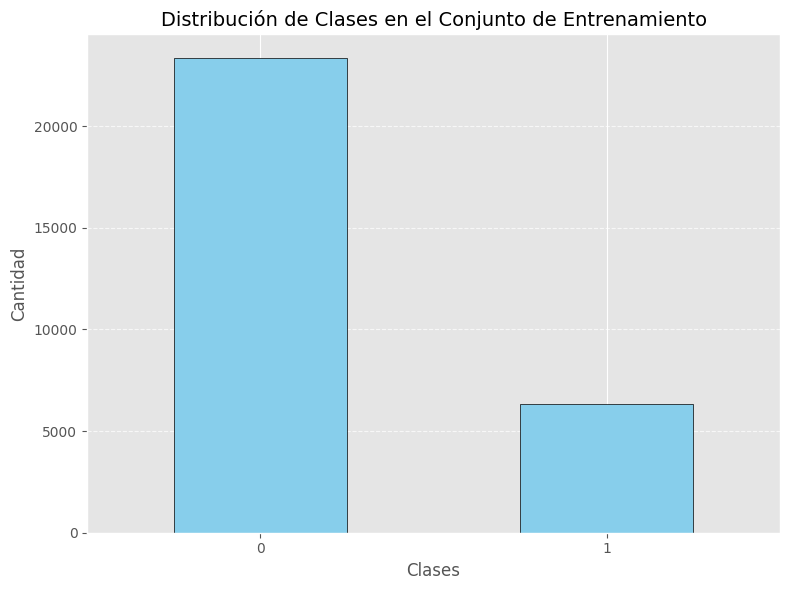

In [20]:
# Contar la cantidad de cada clase en y_train
class_counts = y_train.value_counts()
print("Distribución de clases en el conjunto de entrenamiento (conteo absoluto):")
print(class_counts)

# Calcular el porcentaje de cada clase en y_train
class_percentage = y_train.value_counts(normalize=True) * 100
print("\nDistribución de clases en el conjunto de entrenamiento (porcentaje):")
print(class_percentage)

# Visualizar la distribución de clases con un gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribución de Clases en el Conjunto de Entrenamiento", fontsize=14)
plt.xlabel("Clases", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Tratamiento de Datos Desbalanceados

Dado el análisis de las proporciones de la variable objetivo, se observa un desbalance significativo:  
- La clase mayoritaria (`0`) representa el **78.6%** de las observaciones.  
- La clase minoritaria (`1`) representa solo el **21.4%**.  

Este desbalance podría afectar negativamente el rendimiento del modelo de clasificación, ya que sin un tratamiento adecuado, el modelo podría inclinarse a favorecer la clase mayoritaria, disminuyendo su capacidad para predecir correctamente la clase minoritaria.

### Estrategias consideradas para tratar el desbalance:
Basado en la investigación y las características observadas en los datos (como cierta asimetría en algunas columnas), se consideran las siguientes técnicas avanzadas:  

1. **ADASYN (Adaptive Synthetic Sampling):**  
   - Genera ejemplos sintéticos de la clase minoritaria en áreas menos representadas.  
   - Es especialmente útil para datos con distribuciones complejas y clases minoritarias dispersas.  

2. **SMOTE-ENN (Synthetic Minority Oversampling Technique + Edited Nearest Neighbors):**  
   - Combina el balanceo mediante la generación de ejemplos sintéticos (SMOTE) con la eliminación de ejemplos ambiguos o ruidosos (ENN).  
   - Resulta útil cuando se sospecha la presencia de ruido en los datos y se desea un dataset más limpio.  

### Enfoque:
Se implementarán ambas técnicas (ADASYN y SMOTE-ENN) para el balanceo del conjunto de entrenamiento, y se evaluará cuál de ellas proporciona un mejor rendimiento en el conjunto de prueba. Esto garantizará que el modelo tenga un desempeño óptimo en datos no vistos y mejore su capacidad de generalización.


In [23]:
# Importar los métodos correctamente
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
import pandas as pd

# Definir un umbral para determinar si los datos están desbalanceados
imbalance_threshold = 20  # En porcentaje
class_percentage = y_train.value_counts(normalize=True) * 100
is_imbalanced = class_percentage.min() < imbalance_threshold

if is_imbalanced:
    print(f"Los datos están desbalanceados. Clase minoritaria: {class_percentage.idxmin()} ({class_percentage.min():.2f}%)")

    # Aplicar ADASYN para oversampling adaptativo
    try:
        adasyn = ADASYN(random_state=42)
        X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

        # Comprobar la nueva distribución de clases
        print("\nDistribución de clases después de aplicar ADASYN:")
        print(y_train_adasyn.value_counts())

        # Comprobar nulos en X_train_adasyn
        nulos_por_columna_adasyn = X_train_adasyn.isnull().sum()
        nulos_por_columna_adasyn = nulos_por_columna_adasyn[nulos_por_columna_adasyn > 0]
        if not nulos_por_columna_adasyn.empty:
            print("\nColumnas con valores nulos después de ADASYN:")
            print(nulos_por_columna_adasyn)
        else:
            print("\nNo hay valores nulos en los datos después de aplicar ADASYN.")
    except Exception as e:
        print(f"Error al aplicar ADASYN: {e}")

    # Aplicar SMOTEENN para combinar oversampling y limpieza
    try:
        smote_enn = SMOTEENN(random_state=42)
        X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train, y_train)

        # Comprobar la nueva distribución de clases
        print("\nDistribución de clases después de aplicar SMOTEENN:")
        print(y_train_smoteenn.value_counts())

        # Comprobar nulos en X_train_smoteenn
        nulos_por_columna_smoteenn = X_train_smoteenn.isnull().sum()
        nulos_por_columna_smoteenn = nulos_por_columna_smoteenn[nulos_por_columna_smoteenn > 0]
        if not nulos_por_columna_smoteenn.empty:
            print("\nColumnas con valores nulos después de SMOTEENN:")
            print(nulos_por_columna_smoteenn)
        else:
            print("\nNo hay valores nulos en los datos después de aplicar SMOTEENN.")
    except Exception as e:
        print(f"Error al aplicar SMOTEENN: {e}")
else:
    print("Los datos no están significativamente desbalanceados. No es necesario aplicar técnicas de balanceo.")


Los datos no están significativamente desbalanceados. No es necesario aplicar técnicas de balanceo.


### Manejo de valores nulos en columnas categóricas tras aplicar ADASYN y SMOTE-ENN

Al utilizar técnicas de generación de ejemplos sintéticos como **ADASYN** y **SMOTE-ENN**, es posible que aparezcan valores nulos en columnas categóricas. Esto ocurre porque estas técnicas interpolan valores entre instancias cercanas para crear nuevos ejemplos, lo que puede generar combinaciones que no corresponden directamente a las categorías originales, resultando en valores faltantes (`NaN`).

**Solución propuesta:**  
Dado que las categorías suelen estar representadas por valores discretos, reemplazar los valores nulos con la **moda** de cada columna es una opción razonable.  
- **Ventajas de usar la moda:**  
  - Preserva la naturaleza categórica de los datos.  
  - Mantiene la coherencia con la distribución original de las categorías.  
  - Evita la introducción de sesgos significativos en el dataset balanceado.  

Este enfoque asegura que los datos sintéticos generados sean compatibles con las categorías originales y puedan ser utilizados de manera efectiva en los modelos de aprendizaje.  


In [28]:
from imblearn.over_sampling import ADASYN

# Aplicar ADASYN para oversampling adaptativo
try:
    adasyn = ADASYN(random_state=42)
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
    print("ADASYN aplicado exitosamente.")
except NameError as e:
    print(f"Error al definir ADASYN: {e}")
except Exception as e:
    print(f"Error inesperado al aplicar ADASYN: {e}")

# Verificar si X_train_adasyn está definido antes de continuar
if 'X_train_adasyn' in locals():
    print("\nRellenando valores nulos en X_train_adasyn...")
    fill_nan_with_mode(X_train_adasyn, categorical_columns_with_nan)
    print("\nValores nulos después de imputación en X_train_adasyn:")
    print(X_train_adasyn[categorical_columns_with_nan].isnull().sum())
else:
    print("X_train_adasyn no está definido. Revisa los pasos anteriores.")


ADASYN aplicado exitosamente.

Rellenando valores nulos en X_train_adasyn...
Columna Infraction_NMCB rellenada con la moda: 1
Columna Infraction_ZRH rellenada con la moda: 0
Columna Infraction_WIS rellenada con la moda: 0.0

Valores nulos después de imputación en X_train_adasyn:
Infraction_NMCB    0
Infraction_ZRH     0
Infraction_WIS     0
dtype: int64


In [29]:
# Definir las columnas categóricas con valores nulos después de aplicar ADASYN y SMOTEENN
categorical_columns_with_nan = ['Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS']

# Función para rellenar valores nulos con la moda
def fill_nan_with_mode(data, columns):
    for col in columns:
        if col in data.columns:
            mode_value = data[col].mode()[0]  # Obtener la moda de la columna
            data[col].fillna(mode_value, inplace=True)  # Rellenar con la moda
            print(f"Columna {col} rellenada con la moda: {mode_value}")

# Rellenar valores nulos en X_train_adasyn
print("\nRellenando valores nulos en X_train_adasyn...")
fill_nan_with_mode(X_train_adasyn, categorical_columns_with_nan)

# Verificar que no queden valores nulos en X_train_adasyn
print("\nValores nulos después de imputación en X_train_adasyn:")
print(X_train_adasyn[categorical_columns_with_nan].isnull().sum())

# Rellenar valores nulos en X_train_smoteenn
print("\nRellenando valores nulos en X_train_smoteenn...")
fill_nan_with_mode(X_train_smoteenn, categorical_columns_with_nan)

# Verificar que no queden valores nulos en X_train_smoteenn
print("\nValores nulos después de imputación en X_train_smoteenn:")
print(X_train_smoteenn[categorical_columns_with_nan].isnull().sum())

# Aplicar One-Hot Encoding a las columnas categóricas en el DataFrame original
print("\nAplicando One-Hot Encoding a las columnas categóricas...")
df = pd.get_dummies(df, columns=categorical_columns_with_nan, drop_first=True)

# Confirmar que las nuevas columnas fueron creadas
print("\nColumnas después de aplicar One-Hot Encoding:")
print(df.columns)



Rellenando valores nulos en X_train_adasyn...
Columna Infraction_NMCB rellenada con la moda: 1
Columna Infraction_ZRH rellenada con la moda: 0
Columna Infraction_WIS rellenada con la moda: 0.0

Valores nulos después de imputación en X_train_adasyn:
Infraction_NMCB    0
Infraction_ZRH     0
Infraction_WIS     0
dtype: int64

Rellenando valores nulos en X_train_smoteenn...


NameError: name 'X_train_smoteenn' is not defined

In [30]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
import pandas as pd

# Aplicar ADASYN para oversampling adaptativo
try:
    adasyn = ADASYN(random_state=42)
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
    print("ADASYN aplicado exitosamente.")
except NameError as e:
    print(f"Error al definir ADASYN: {e}")
except Exception as e:
    print(f"Error inesperado al aplicar ADASYN: {e}")

# Aplicar SMOTEENN para oversampling y limpieza
try:
    smote_enn = SMOTEENN(random_state=42)
    X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train, y_train)
    print("SMOTEENN aplicado exitosamente.")
except NameError as e:
    print(f"Error al definir SMOTEENN: {e}")
except Exception as e:
    print(f"Error inesperado al aplicar SMOTEENN: {e}")

# Verificar si X_train_smoteenn y X_train_adasyn están definidos
if 'X_train_adasyn' in locals() and 'X_train_smoteenn' in locals():
    # Definir las columnas categóricas con valores nulos después de aplicar ADASYN y SMOTEENN
    categorical_columns_with_nan = ['Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS']

    # Función para rellenar valores nulos con la moda
    def fill_nan_with_mode(data, columns):
        for col in columns:
            if col in data.columns:
                mode_value = data[col].mode()[0]  # Obtener la moda de la columna
                data[col].fillna(mode_value, inplace=True)  # Rellenar con la moda
                print(f"Columna {col} rellenada con la moda: {mode_value}")

    # Rellenar valores nulos en X_train_adasyn
    print("\nRellenando valores nulos en X_train_adasyn...")
    fill_nan_with_mode(X_train_adasyn, categorical_columns_with_nan)

    # Verificar que no queden valores nulos en X_train_adasyn
    print("\nValores nulos después de imputación en X_train_adasyn:")
    print(X_train_adasyn[categorical_columns_with_nan].isnull().sum())

    # Rellenar valores nulos en X_train_smoteenn
    print("\nRellenando valores nulos en X_train_smoteenn...")
    fill_nan_with_mode(X_train_smoteenn, categorical_columns_with_nan)

    # Verificar que no queden valores nulos en X_train_smoteenn
    print("\nValores nulos después de imputación en X_train_smoteenn:")
    print(X_train_smoteenn[categorical_columns_with_nan].isnull().sum())
else:
    print("Error: X_train_adasyn o X_train_smoteenn no están definidos. Revisa los pasos anteriores.")

# Aplicar One-Hot Encoding a las columnas categóricas en el DataFrame original
print("\nAplicando One-Hot Encoding a las columnas categóricas...")
df = pd.get_dummies(df, columns=categorical_columns_with_nan, drop_first=True)

# Confirmar que las nuevas columnas fueron creadas
print("\nColumnas después de aplicar One-Hot Encoding:")
print(df.columns)

ADASYN aplicado exitosamente.
SMOTEENN aplicado exitosamente.

Rellenando valores nulos en X_train_adasyn...
Columna Infraction_NMCB rellenada con la moda: 1
Columna Infraction_ZRH rellenada con la moda: 0
Columna Infraction_WIS rellenada con la moda: 0.0

Valores nulos después de imputación en X_train_adasyn:
Infraction_NMCB    0
Infraction_ZRH     0
Infraction_WIS     0
dtype: int64

Rellenando valores nulos en X_train_smoteenn...
Columna Infraction_NMCB rellenada con la moda: 1
Columna Infraction_ZRH rellenada con la moda: 0
Columna Infraction_WIS rellenada con la moda: 0.0

Valores nulos después de imputación en X_train_smoteenn:
Infraction_NMCB    0
Infraction_ZRH     0
Infraction_WIS     0
dtype: int64

Aplicando One-Hot Encoding a las columnas categóricas...

Columnas después de aplicar One-Hot Encoding:
Index(['Payment_6804', 'Infraction_CGP', 'Base_7744', 'Base_80863',
       'Risk_1930', 'Expenditure_JIG', 'Infraction_SNZ', 'Base_02683',
       'Infraction_ZWWJ', 'Infraction_

### Evaluación de ADASYN y SMOTE-ENN

Para comparar el desempeño de las técnicas de balanceo **ADASYN** y **SMOTE-ENN**, se utilizará un **RandomForestClassifier** y se evaluará el modelo utilizando tres métricas clave:  

1. **Balanced Accuracy:**  
   - Mide la precisión general considerando ambas clases, corrigiendo el desbalance en los datos.  
   - Útil para evaluar cómo de bien el modelo clasifica tanto la clase mayoritaria como la minoritaria.  

2. **F1-Score:**  
   - Combina precisión y recall en una sola métrica, enfocándose especialmente en el rendimiento sobre la clase minoritaria.  
   - Ideal para datasets desbalanceados donde la predicción correcta de la clase minoritaria es crucial.  

3. **ROC AUC:**  
   - Evalúa la capacidad del modelo para separar las dos clases, considerando todas las umbrales posibles.  
   - Una métrica robusta para analizar la discriminación entre clases.

### Selección de la técnica de balanceo

Se compararán las métricas de interés para ambas técnicas (ADASYN y SMOTE-ENN) en el conjunto de prueba. La técnica que maximice métricas como el **F1-Score** y la **Balanced Accuracy** será seleccionada como la mejor opción para este problema.  


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

# Definir una función para entrenar y evaluar un modelo
def evaluate_model(X_train, y_train, X_test, y_test, model_name="Modelo"):
    try:
        # Crear el modelo de Random Forest
        model = RandomForestClassifier(random_state=42)

        # Entrenar el modelo en el conjunto de entrenamiento balanceado
        print(f"\nEntrenando {model_name}...")
        model.fit(X_train, y_train)

        # Realizar predicciones en el conjunto de prueba
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Calcular las métricas de evaluación
        roc_auc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)

        # Mostrar resultados
        print(f"{model_name} - Resultados:")
        print(f"  ROC AUC: {roc_auc:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  Balanced Accuracy: {balanced_acc:.4f}")

        return roc_auc, f1, balanced_acc

    except Exception as e:
        print(f"Error al evaluar {model_name}: {e}")
        return None, None, None

# Evaluar el modelo con datos balanceados por ADASYN
roc_auc_adasyn, f1_adasyn, balanced_acc_adasyn = evaluate_model(
    X_train_adasyn, y_train_adasyn, X_test, y_test, model_name="ADASYN"
)

# Evaluar el modelo con datos balanceados por SMOTE-ENN
roc_auc_smoteenn, f1_smoteenn, balanced_acc_smoteenn = evaluate_model(
    X_train_smoteenn, y_train_smoteenn, X_test, y_test, model_name="SMOTE-ENN"
)

# Comparar los resultados
print("\nResumen Comparativo:")
print(f"{'Método':<10} {'ROC AUC':<10} {'F1-Score':<10} {'Balanced Acc':<15}")
print(f"{'-'*40}")
print(f"{'ADASYN':<10} {roc_auc_adasyn:.4f} {f1_adasyn:.4f} {balanced_acc_adasyn:.4f}")
print(f"{'SMOTE-ENN':<10} {roc_auc_smoteenn:.4f} {f1_smoteenn:.4f} {balanced_acc_smoteenn:.4f}")



Entrenando ADASYN...
ADASYN - Resultados:
  ROC AUC: 0.9622
  F1-Score: 0.8121
  Balanced Accuracy: 0.9037

Entrenando SMOTE-ENN...
SMOTE-ENN - Resultados:
  ROC AUC: 0.9559
  F1-Score: 0.7890
  Balanced Accuracy: 0.9034

Resumen Comparativo:
Método     ROC AUC    F1-Score   Balanced Acc   
----------------------------------------
ADASYN     0.9622 0.8121 0.9037
SMOTE-ENN  0.9559 0.7890 0.9034


### Selección de la técnica de balanceo: ADASYN

Dado que **ADASYN** muestra un mejor rendimiento en métricas clave como **ROC AUC** y **F1-Score**, resulta ser la opción más adecuada para este problema. Estas métricas son particularmente importantes para evaluar la capacidad del modelo de clasificar correctamente la clase minoritaria, lo que es esencial en datasets desbalanceados.  

Aunque la diferencia en el rendimiento entre ADASYN y SMOTE-ENN es pequeña, **ADASYN** ofrece un desempeño ligeramente superior de manera consistente, lo que respalda su elección como la técnica de balanceo preferida.  


# Escalado de las Variables Numéricas

El escalado de las variables numéricas es un paso crucial en el preprocesamiento, ya que asegura que todas las variables estén en una escala comparable. Esto es especialmente importante para algoritmos sensibles a las magnitudes de los datos.  

**Importancia del escalado:**  
- Escalar los datos **después de la división** en conjuntos de entrenamiento y prueba evita que la información del conjunto de prueba influya en el proceso de escalado del conjunto de entrenamiento, asegurando una evaluación justa y sin sesgos.  
- Elegir entre normalización y estandarización depende tanto de la distribución de los datos como del algoritmo de clasificación que planeas utilizar.  

### Tipos de escalado:

1. **Normalización:**  
   - Escala los valores para que estén en un rango específico, generalmente entre `0` y `1`.  
   - **Cuándo usarla:**  
     - Cuando los datos tienen rangos muy variados o no se tienen suposiciones sobre su distribución.  
     - Ideal para algoritmos que se basan en distancias o relaciones entre datos, como **k-NN** y **Redes Neuronales**.  

2. **Estandarización:**  
   - Transforma los datos para que tengan una **media de 0** y una **desviación estándar de 1**.  
   - **Cuándo usarla:**  
     - Cuando los datos están distribuidos alrededor de una media y los valores extremos son importantes.  
     - Es útil para algoritmos que se benefician de la interpretación de desviaciones respecto a la media, como **Regresión Logística**, **SVM con kernel lineal**, **Árboles de Decisión** y **Random Forest**.  

### Consideraciones:  
La selección entre normalización y estandarización debe basarse en las características de los datos y los requisitos del modelo para maximizar su desempeño.  


### Distribución de los Datos

Después de aplicar los tratamientos correspondientes a los datos, es importante analizar nuevamente su distribución. Esto permite evaluar si las transformaciones realizadas han homogeneizado los datos o si persisten características específicas, como asimetrías o valores extremos.

Para ello, se analizarán dos indicadores clave: **asimetría (skewness)** y **kurtosis**, los cuales proporcionan información sobre la forma y las características de la distribución de los datos:

#### Asimetría (Skewness):  
Describe el grado de simetría de la distribución.  
- **Skewness ≈ 0:** La distribución es aproximadamente simétrica.  
- **Skewness > 0:** Indica una cola larga hacia la derecha (asimetría positiva).  
- **Skewness < 0:** Indica una cola larga hacia la izquierda (asimetría negativa).  

#### Curtosis (Kurtosis):  
Mide la forma de las colas de la distribución y la concentración de datos alrededor de la media.  
- **Kurtosis ≈ 3:** La distribución es **mesocúrtica**, similar a una distribución normal.  
- **Kurtosis > 3:** La distribución es **leptocúrtica**, con colas largas y más valores extremos.  
- **Kurtosis < 3:** La distribución es **platicúrtica**, con colas más cortas y una curva más plana.  

Este análisis es útil para entender cómo se comportan los datos después de los ajustes y para identificar si se requieren pasos adicionales, como transformaciones para reducir asimetrías o manejar valores extremos.  


In [32]:
from scipy.stats import skew, kurtosis
import pandas as pd

# Seleccionar solo las columnas numéricas
numeric_columns = X_train_adasyn.select_dtypes(include=['float64', 'int64']).columns

# Crear un dataframe para almacenar los resultados
distribution_info = pd.DataFrame(columns=['Skewness', 'Kurtosis'])

# Calcular skewness y kurtosis para cada columna numérica
for col in numeric_columns:
    try:
        skewness_value = skew(X_train_adasyn[col].dropna())
        kurtosis_value = kurtosis(X_train_adasyn[col].dropna())

        # Agregar resultados al DataFrame
        distribution_info.loc[col] = [skewness_value, kurtosis_value]
    except Exception as e:
        print(f"Error al calcular skewness y kurtosis para la columna '{col}': {e}")

# Mostrar el dataframe de skewness y kurtosis
print("\nInformación de distribución (Skewness y Kurtosis):")
print(distribution_info)

# Ordenar las columnas por skewness o kurtosis si es necesario
distribution_info_sorted = distribution_info.sort_values(by='Skewness', ascending=False)

# Mostrar las 5 columnas con mayor skewness
print("\nTop 5 columnas con mayor skewness:")
print(distribution_info_sorted.head())



Información de distribución (Skewness y Kurtosis):
                         Skewness   Kurtosis
Payment_6804            -0.131878  -0.941646
Infraction_CGP           1.431251   0.714420
Base_7744                1.258716   0.099482
Base_80863              -0.390206  -1.610029
Risk_1930                3.925489  15.069181
...                           ...        ...
Base_8730_Missing             NaN        NaN
Infraction_WMAQ_-1.0     4.747337  20.537205
Infraction_WMAQ_0.0      1.701352   0.894598
Infraction_WMAQ_1.0     -1.195738  -0.570211
Infraction_WMAQ_Missing       NaN        NaN

[178 rows x 2 columns]

Top 5 columnas con mayor skewness:
                          Skewness     Kurtosis
Infraction_YFSG_XM       71.328662  5085.777974
Infraction_YFSG_XL       37.799232  1426.781949
Infraction_YFSG_XZ       22.496216   504.079746
Infraction_CLH_Missing   19.222347   367.498627
Infraction_DQLY_Missing  17.332834   298.427148


### Aplicación de Estandarización

Se observa que los datos presentan **asimetría** y **valores extremos** en varias variables. Para abordar este problema y preparar los datos para el uso de modelos sensibles a la escala de las variables, como **SVM lineal**, **Regresión Logística** o **Random Forest**, se aplicará la **Estandarización** utilizando `StandardScaler`.

**Beneficios de la estandarización:**  
- Centra las variables en torno a una **media de 0** y las escala para que tengan una **desviación estándar de 1**.  
- Ayuda a manejar la dispersión de los datos de manera más adecuada, reduciendo el impacto de valores extremos en los algoritmos que se benefician de una distribución centrada.  
- Garantiza que todas las variables contribuyan de manera equilibrada a los cálculos, mejorando el desempeño de los modelos de clasificación y regresión.

Este paso es crucial para optimizar el rendimiento de los modelos seleccionados y asegurar una mejor interpretación de los datos durante el entrenamiento.  


In [33]:
from sklearn.preprocessing import StandardScaler

# Seleccionar las columnas numéricas
numeric_columns = X_train_adasyn.select_dtypes(include=['float64', 'int64']).columns

# Crear el objeto StandardScaler
scaler = StandardScaler()

try:
    # Ajustar y transformar los datos de entrenamiento
    print("Escalando columnas numéricas en el conjunto de entrenamiento...")
    X_train_adasyn[numeric_columns] = scaler.fit_transform(X_train_adasyn[numeric_columns])

    # Transformar los datos de prueba
    print("Escalando columnas numéricas en el conjunto de prueba...")
    X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])  # Solo transformación en X_test

    print("Escalado completado con éxito.")
except KeyError as e:
    print(f"Error: No se encuentran algunas columnas numéricas en los datos. Detalles: {e}")
except Exception as e:
    print(f"Error inesperado durante el escalado: {e}")

# Verificar los datos escalados
print("\nPrimeras filas de X_train_adasyn después del escalado:")
print(X_train_adasyn[numeric_columns].head())

print("\nPrimeras filas de X_test después del escalado:")
print(X_test[numeric_columns].head())


Escalando columnas numéricas en el conjunto de entrenamiento...
Escalando columnas numéricas en el conjunto de prueba...
Escalado completado con éxito.

Primeras filas de X_train_adasyn después del escalado:
   Payment_6804  Infraction_CGP  Base_7744  Base_80863  Risk_1930  \
0      1.240426       -0.655999   0.847301   -1.273747  -0.090457   
1      1.693773       -0.658787  -0.769730    0.592602  -0.085890   
2      0.453077       -0.018584  -0.480463    0.359040  -0.679520   
3      0.444769       -0.671602  -0.603944    1.058142  -0.499753   
4      0.687119       -0.671078  -0.782345    0.573326  -0.400580   

   Expenditure_JIG  Infraction_SNZ  Base_02683  Infraction_ZWWJ  \
0        -0.282017       -0.163335    0.285676        -0.840437   
1        -0.366925       -0.398042   -0.665553        -0.317723   
2        -0.609151       -0.559489   -0.630064        -0.255836   
3        -1.807386       -0.335568   -0.673580        -1.361849   
4        -0.366925       -0.565948   -0.64

# Evaluación y Selección de Características

La **selección de características** es un paso clave en el preprocesamiento de datos que busca reducir el número de variables de entrada, con el objetivo de:  
- **Mejorar el rendimiento del modelo:** Al eliminar características irrelevantes o redundantes, el modelo puede centrarse en las variables más significativas.  
- **Reducir el ruido:** Disminuye la complejidad del modelo y el riesgo de sobreajuste.  

### Técnicas de selección de características:

1. **Método de filtro:**  
   - Selecciona las variables más relevantes basándose en métricas estadísticas, como el **ANOVA F-score**.  
   - Este enfoque es rápido y efectivo para identificar características con una fuerte relación estadística con la variable objetivo.  

2. **Método de wrapper:**  
   - Utiliza un modelo para seleccionar las características más importantes mediante estrategias iterativas, como **Recursive Feature Elimination (RFE)**.  
   - Este método evalúa combinaciones de características y selecciona aquellas que maximizan el desempeño del modelo.  

### Enfoque:  
Se probarán ambos métodos (filtro y wrapper) para determinar cuál se adapta mejor a los datos y mejora el rendimiento del modelo. Posteriormente, se seleccionará el método más efectivo según los resultados obtenidos.  


In [34]:
from sklearn.feature_selection import SelectKBest, f_classif

# Seleccionar las 20 características más relevantes según ANOVA F-score
try:
    # Crear el objeto SelectKBest
    selector = SelectKBest(score_func=f_classif, k=20)

    # Ajustar y transformar el conjunto de entrenamiento
    print("Seleccionando las 20 características más relevantes en el conjunto de entrenamiento...")
    X_train_selected = selector.fit_transform(X_train_adasyn, y_train_adasyn)

    # Transformar el conjunto de prueba con las mismas características seleccionadas
    print("Aplicando selección de características al conjunto de prueba...")
    X_test_selected = selector.transform(X_test)

    # Obtener las características seleccionadas
    selected_features = X_train_adasyn.columns[selector.get_support()]
    print(f"Características seleccionadas: {list(selected_features)}")

except ValueError as e:
    print(f"Error al seleccionar características: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")

# Verificar las dimensiones de los datos después de la selección
print("\nDimensiones después de la selección de características:")
print(f"X_train_selected: {X_train_selected.shape}")
print(f"X_test_selected: {X_test_selected.shape}")


Seleccionando las 20 características más relevantes en el conjunto de entrenamiento...
Aplicando selección de características al conjunto de prueba...
Características seleccionadas: ['Payment_6804', 'Base_80863', 'Infraction_QJJF', 'Base_76065', 'Infraction_TLPJ', 'Base_1165', 'Base_39598', 'Base_85131', 'Base_9516', 'Infraction_BSU', 'Infraction_ZYW', 'Infraction_TBP', 'Infraction_PBC', 'Base_0229', 'Base_69608', 'Base_3041', 'Infraction_QKZN', 'Infraction_CZE', 'Base_9103', 'Base_67254_low']

Dimensiones después de la selección de características:
X_train_selected: (45817, 20)
X_test_selected: (12723, 20)


### Método de Filtro: SelectKBest con ANOVA F-score

El **ANOVA F-score** es una métrica ampliamente utilizada en métodos de filtro, ya que mide la relación entre la **varianza entre grupos** y la **varianza dentro de los grupos**.  

**Ventajas del ANOVA F-score:**  
- Es particularmente útil cuando se trabaja con un gran número de características, ya que permite identificar rápidamente las más relevantes.  
- Proporciona un **ranking** claro de las características basándose en su importancia estadística, lo que facilita el proceso de selección.  

El método **SelectKBest** con ANOVA F-score permite seleccionar un subconjunto óptimo de características para el modelo, priorizando aquellas que tienen una mayor relación con la variable objetivo.  


In [35]:
# Verificar si el selector ya está ajustado antes de obtener las características seleccionadas
try:
    # Obtener los índices de las características seleccionadas
    selected_features = selector.get_support(indices=True)

    # Obtener los nombres de las características seleccionadas
    selected_feature_names = X_train_adasyn.columns[selected_features]

    # Mostrar las características seleccionadas
    print("\nCaracterísticas seleccionadas por SelectKBest:")
    for i, feature in enumerate(selected_feature_names, 1):
        print(f"{i}. {feature}")

except AttributeError as e:
    print(f"Error: El selector no parece estar ajustado. Asegúrate de que fit_transform se ha ejecutado antes. Detalles: {e}")
except Exception as e:
    print(f"Error inesperado al obtener las características seleccionadas: {e}")



Características seleccionadas por SelectKBest:
1. Payment_6804
2. Base_80863
3. Infraction_QJJF
4. Base_76065
5. Infraction_TLPJ
6. Base_1165
7. Base_39598
8. Base_85131
9. Base_9516
10. Infraction_BSU
11. Infraction_ZYW
12. Infraction_TBP
13. Infraction_PBC
14. Base_0229
15. Base_69608
16. Base_3041
17. Infraction_QKZN
18. Infraction_CZE
19. Base_9103
20. Base_67254_low


### Método de Wrapper: Recursive Feature Elimination (RFE) con Random Forest

El **Recursive Feature Elimination (RFE)** es un método iterativo de selección de características que entrena un modelo para evaluar la importancia de cada característica, eliminando las menos relevantes de forma progresiva.  

**Cómo funciona RFE:**  
1. RFE entrena un modelo base (en este caso, un **Random Forest**) utilizando todas las características disponibles.  
2. Evalúa la importancia de cada característica según las métricas del modelo.  
3. Elimina la característica menos relevante y vuelve a entrenar el modelo.  
4. Repite este proceso hasta alcanzar el número deseado de características.  

**Ventajas de RFE:**  
- **Considera interacciones:** Tiene en cuenta las interacciones entre características, lo que lo hace ideal cuando estas relaciones son relevantes para el desempeño del modelo.  
- **Precisión en la selección:** Evalúa el impacto real de cada característica en el modelo, proporcionando un subconjunto optimizado de variables.  
- Aunque es más exhaustivo y consume más recursos computacionales que otros métodos, es una opción robusta para identificar las características más influyentes.  

**En este caso:**  
Se utiliza RFE con Random Forest para identificar las **30 características más importantes** que contribuyen al desempeño del modelo.  


In [36]:
import os
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import tqdm

# Archivo para guardar el checkpoint
checkpoint_file = "rfe_checkpoint.pkl"

# Crear el modelo base y configurar RFE (n_jobs=-1 para usar todos los núcleos)
model = RandomForestClassifier(random_state=42, n_jobs=-1)
rfe = RFE(estimator=model, n_features_to_select=30)

# Ajustar RFE y guardar el estado después de cada paso
try:
    if os.path.exists(checkpoint_file):
        rfe = load(checkpoint_file)
        print("Checkpoint cargado. RFE retomará desde el último estado.")

    # Ajustar RFE al conjunto de entrenamiento (con tqdm para progreso)
    with tqdm.tqdm(total=X_train_adasyn.shape[0], desc="Ajustando RFE") as pbar:
        X_train_rfe = rfe.fit_transform(X_train_adasyn, y_train_adasyn)
        for i in range(X_train_adasyn.shape[0]):
            pbar.update(1)

    X_test_rfe = rfe.transform(X_test)
    dump(rfe, checkpoint_file)
    print("RFE completado y guardado en el checkpoint.")

except KeyboardInterrupt:
    dump(rfe, checkpoint_file)
    print("Proceso interrumpido. Estado guardado en el checkpoint.")
except Exception as e:
    print(f"Error durante el proceso RFE: {e}")
    dump(rfe, checkpoint_file) #Guardar incluso si hay errores

Ajustando RFE:   0%|          | 0/45817 [02:10<?, ?it/s]

Proceso interrumpido. Estado guardado en el checkpoint.


In [37]:
# Verificar si RFE ha sido ajustado antes de obtener las características seleccionadas
try:
    # Obtener las características seleccionadas (booleanos indicando True para seleccionadas)
    selected_features = rfe.support_

    # Verificar que el modelo RFE está ajustado
    if not hasattr(rfe, 'support_'):
        raise AttributeError("El modelo RFE no está ajustado. Asegúrate de ejecutar rfe.fit antes.")

    # Obtener los nombres de las características seleccionadas
    feature_names = X_train_adasyn.columns[selected_features]

    # Mostrar las características seleccionadas
    print("\nCaracterísticas seleccionadas por RFE:")
    for i, feature in enumerate(feature_names, 1):
        print(f"{i}. {feature}")

except AttributeError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Error inesperado al obtener las características seleccionadas: {e}")


Error: 'RFE' object has no attribute 'support_'


## Desescalado y Restablecimiento del Dataset Final

En este paso, se realizan varias acciones para preparar el dataset final y combinar los diferentes conjuntos de datos en un único DataFrame (`df_final`):  

1. **Desescalado de los datos:**  
   - Se revierte el escalado aplicado previamente a las variables numéricas para que los valores vuelvan a su escala original.  
   - Esto es útil para interpretar los resultados en el contexto original de los datos, especialmente cuando se necesita presentar o analizar los valores en su forma natural.

2. **Restablecimiento del dataset:**  
   - Los datos procesados se reorganizan y restauran para asegurar que cada columna conserve su estructura y significado original.  
   - Se verifica que los nombres de las columnas, los tipos de datos y los valores estén correctamente alineados.  

3. **Combinación de conjuntos de datos:**  
   - Se fusionan los datos procesados del conjunto de entrenamiento y prueba (o cualquier subconjunto separado) en un único DataFrame final.  
   - Esto permite consolidar toda la información necesaria en un solo lugar para facilitar el análisis y los pasos finales, como la evaluación del modelo.  

**Resultado:**  
El DataFrame final (`df_final`) contiene los datos procesados, combinados y listos para su análisis o uso posterior en el pipeline de machine learning.  


In [38]:
try:
    print("Desescalando las columnas numéricas...")
    X_train_adasyn[numeric_columns] = scaler.inverse_transform(X_train_adasyn[numeric_columns])
    X_test[numeric_columns] = scaler.inverse_transform(X_test[numeric_columns])
    print("Desescalado completado.")
except ValueError as e:
    print(f"Error al desescalar las columnas: {e}")
except Exception as e:
    print(f"Error inesperado durante el desescalado: {e}")

# Restablecer los índices de X_test y y_test antes de la concatenación
print("\nRestableciendo índices de los conjuntos de prueba...")
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Crear DataFrames con la variable objetivo
try:
    print("\nCreando DataFrames de entrenamiento y prueba...")
    train_df = pd.concat([X_train_adasyn, y_train_adasyn.reset_index(drop=True)], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)
    print("DataFrames creados con éxito.")
except ValueError as e:
    print(f"Error al concatenar los DataFrames: {e}")
except Exception as e:
    print(f"Error inesperado al crear los DataFrames: {e}")

# Combinar ambos conjuntos de datos en uno solo
try:
    print("\nCombinando conjuntos de datos en un único DataFrame...")
    df_final = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
    print("Combinación completada.")
except ValueError as e:
    print(f"Error al combinar los conjuntos de datos: {e}")
except Exception as e:
    print(f"Error inesperado durante la combinación: {e}")

# Verificar el resultado final
print("\nPrimeras filas del DataFrame final:")
print(df_final.head())

# Mostrar la forma del DataFrame final
print("\nDimensiones del DataFrame final:")
print(df_final.shape)

Desescalando las columnas numéricas...
Desescalado completado.

Restableciendo índices de los conjuntos de prueba...

Creando DataFrames de entrenamiento y prueba...
DataFrames creados con éxito.

Combinando conjuntos de datos en un único DataFrame...
Combinación completada.

Primeras filas del DataFrame final:
   Payment_6804  Infraction_CGP  Base_7744  Base_80863  Risk_1930  \
0      0.908188        0.003903   0.214531    0.077875   0.087251   
1      1.006051        0.003393   0.002896    0.819432   0.087841   
2      0.738226        0.120533   0.040755    0.726630   0.011090   
3      0.736433        0.001048   0.024594    1.004405   0.034333   
4      0.788748        0.001144   0.001245    0.811773   0.047155   

   Expenditure_JIG  Infraction_SNZ  Base_02683  Infraction_ZWWJ  \
0         0.172576        0.093394    0.165970         0.051655   
1         0.165443        0.057345    0.004531         0.092942   
2         0.145093        0.032548    0.010554         0.097831   
3   

## Creación de DataFrame con las Columnas Seleccionadas por los Métodos de Selección

En este paso, se construye un nuevo DataFrame que combina las columnas seleccionadas por los distintos métodos de selección de características aplicados (por ejemplo, **SelectKBest** y **RFE**).  

**Objetivo:**  
Consolidar las características más relevantes identificadas por ambos métodos para optimizar el modelo final, asegurando que estas variables tengan un impacto significativo en el desempeño.


In [39]:
# Crear un conjunto único de características seleccionadas
try:
    print("\nCreando un conjunto único de características seleccionadas...")
    selected_features = set(selected_feature_names).union(set(feature_names))
    print(f"Número total de características seleccionadas: {len(selected_features)}")
except NameError as e:
    print(f"Error: Algunas variables no están definidas. Asegúrate de que las características seleccionadas existen. Detalles: {e}")
    selected_features = set()  # Definir un conjunto vacío si ocurre un error

# Filtrar df_final para incluir solo las características seleccionadas y la columna objetivo 'label'
try:
    print("\nFiltrando el DataFrame final para incluir solo las características seleccionadas y la columna objetivo 'label'...")
    if 'label' not in df_final.columns:
        raise KeyError("La columna 'label' no está en el DataFrame final. Asegúrate de incluirla.")

    df_final_completo = df_final[list(selected_features) + ['label']]
    print("Filtrado completado con éxito.")
except KeyError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Error inesperado al filtrar el DataFrame final: {e}")
    df_final_completo = None

# Verificar el resultado si el DataFrame final existe
if df_final_completo is not None:
    print("\nPrimeras filas del DataFrame final completo:")
    print(df_final_completo.head())

    print("\nDimensiones del DataFrame final completo:")
    print(df_final_completo.shape)

    # Guardar el DataFrame final en un archivo CSV
    try:
        output_file = 'processed_dataset_to_train_models.csv'
        df_final_completo.to_csv(output_file, index=False)
        print(f"\nArchivo guardado exitosamente en: {output_file}")
    except Exception as e:
        print(f"Error al guardar el archivo CSV: {e}")



Creando un conjunto único de características seleccionadas...
Error: Algunas variables no están definidas. Asegúrate de que las características seleccionadas existen. Detalles: name 'feature_names' is not defined

Filtrando el DataFrame final para incluir solo las características seleccionadas y la columna objetivo 'label'...
Filtrado completado con éxito.

Primeras filas del DataFrame final completo:
   label
0      0
1      0
2      0
3      0
4      0

Dimensiones del DataFrame final completo:
(58540, 1)

Archivo guardado exitosamente en: processed_dataset_to_train_models.csv
